In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from packaging.version import Version
from pymongo import MongoClient
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_formats="retina"

In [2]:
tf_versioned_sc = json.load(open(f"data/TensorFlow/versioned_sc.json"))
tf_versioned_sc = sorted(tf_versioned_sc.items(), key=lambda x: Version(x[0]))
pt_versioned_sc = json.load(open(f"data/PyTorch/versioned_sc.json"))
pt_versioned_sc = sorted(pt_versioned_sc.items(), key=lambda x: Version(x[0]))

In [3]:
tf_sc_ver_pkgs = {}
pt_sc_ver_pkgs = {}

for ver, sc in tf_versioned_sc:
    tmp = []
    for layer, pkgs in sc.items():
        tmp.extend(pkgs)
    tmp = list(set(tmp))
    tf_sc_ver_pkgs[ver] = tmp

for ver, sc in pt_versioned_sc:
    tmp = []
    for layer, pkgs in sc.items():
        tmp.extend(pkgs)
    tmp = list(set(tmp))
    pt_sc_ver_pkgs[ver] = tmp

print(len(tf_sc_ver_pkgs), len(pt_sc_ver_pkgs))

62 27


In [4]:
sc_db = MongoClient(host="127.0.0.1", port=27017)["dlsc"]
dist_meta = MongoClient(host="127.0.0.1", port=27017)["dlsc"]["distribution_metadata"]

In [5]:
def sc_version_ratio(sc: str):
    data = json.load(open(f"data/{sc}/package_version_info.json"))
    same = 0
    leave = 0
    res = []
    edges = sc_db[f"{sc}_edges"]
    for p in data.keys():
        pypi_version = data[p]["pypi_version"]
        sc_version = data[p]["sc_version"]
        if len(pypi_version) == len(sc_version):
            same += 1
        elif pypi_version and sc_version:
            if pypi_version[-1] != sc_version[-1]:
                leave += 1
                v = sc_version[-1]
                # layers = list(
                #     pd.DataFrame(
                #         edges.find(
                #             {"name": p, "version": v},
                #             projection={"_id": 0, "layer": 1},
                #         )
                #     )["layer"].unique()
                # )
                deps = list(
                    pd.DataFrame(
                        edges.find(
                            {"name": p, "version": v},
                            projection={"_id": 0, "dependency": 1},
                        )
                    )["dependency"].unique()
                )
                # layers.sort()
                versions = pypi_version[pypi_version.index(sc_version[-1]) :]
                has_req = False
                for left_version in versions[1:]:
                    try:
                        has_req = any(
                            pd.DataFrame(
                                dist_meta.find(
                                    {"name": p, "version": left_version},
                                    projection={"_id": 0, "requires_dist": 1},
                                )
                            )["requires_dist"].values
                        )
                    except:
                        print(p, left_version)
                    if has_req:
                        break
                if has_req:
                    res.append(
                        [
                            sc,
                            p,
                            # ",".join([str(l) for l in layers]),
                            ",".join(deps),
                            sc_version[-1],
                            dist_meta.find({"name": p, "version": sc_version[-1]})
                            .next()["upload_time"]
                            .split(" ")[0],
                            dist_meta.find({"name": p, "version": versions[1]})
                            .next()["upload_time"]
                            .split(" ")[0],
                            dist_meta.find({"name": p, "version": pypi_version[0]})
                            .next()["upload_time"]
                            .split(" ")[0],
                            dist_meta.find({"name": p, "version": pypi_version[-1]})
                            .next()["upload_time"]
                            .split(" ")[0],
                        ]
                    )

    res = pd.DataFrame(
        res,
        columns=[
            "framework",
            "package",
            # "layers",
            "dependencies",
            "last version",
            "sc_latest_version_time",
            "deprecate_time",
            "pypi_first_version_time",
            "pypi_latest_version_time",
        ],
    )
    return res


left_packages = pd.DataFrame()
left_packages = left_packages.append(sc_version_ratio("PyTorch"), ignore_index=True)
left_packages = left_packages.append(sc_version_ratio("TensorFlow"), ignore_index=True)
left_packages.head()

,framework,package,dependencies,last version,sc_latest_version_time,deprecate_time,pypi_first_version_time,pypi_latest_version_time
0,PyTorch,tonic,"torch,torchvision",0.3.10,2021-06-22,2021-07-05,2020-06-10,2021-11-12
1,PyTorch,clinica,"torch,torchvision",0.5.1,2021-09-21,2021-10-12,2019-03-08,2021-10-12
2,PyTorch,alectio-sdk,"torch,torchtext,torchvision",0.0.3,2020-09-05,2020-11-20,2020-09-04,2021-04-13
3,PyTorch,pytorch-rex,torch,0.0.0,2020-11-11,2021-07-28,2020-11-11,2021-11-09
4,PyTorch,aim-cli,"torch,torchvision",1.1.0,2020-01-12,2020-01-13,2019-09-20,2021-10-11


In [6]:
left_packages.groupby("framework")["package"].count()

framework
PyTorch       201
TensorFlow    364
Name: package, dtype: int64

In [7]:
left_packages.loc[:, "deprecate_time"] = pd.to_datetime(left_packages["deprecate_time"])
left_packages.head()

,framework,package,dependencies,last version,sc_latest_version_time,deprecate_time,pypi_first_version_time,pypi_latest_version_time
0,PyTorch,tonic,"torch,torchvision",0.3.10,2021-06-22,2021-07-05,2020-06-10,2021-11-12
1,PyTorch,clinica,"torch,torchvision",0.5.1,2021-09-21,2021-10-12,2019-03-08,2021-10-12
2,PyTorch,alectio-sdk,"torch,torchtext,torchvision",0.0.3,2020-09-05,2020-11-20,2020-09-04,2021-04-13
3,PyTorch,pytorch-rex,torch,0.0.0,2020-11-11,2021-07-28,2020-11-11,2021-11-09
4,PyTorch,aim-cli,"torch,torchvision",1.1.0,2020-01-12,2020-01-13,2019-09-20,2021-10-11


framework,deprecate_time,PyTorch,TensorFlow
0,2017-03,0,2
1,2017-06,0,1
2,2017-09,1,4
3,2017-12,0,4
4,2018-03,0,5
5,2018-06,1,3
6,2018-09,1,6
7,2018-12,4,13
8,2019-03,3,12
9,2019-06,5,21


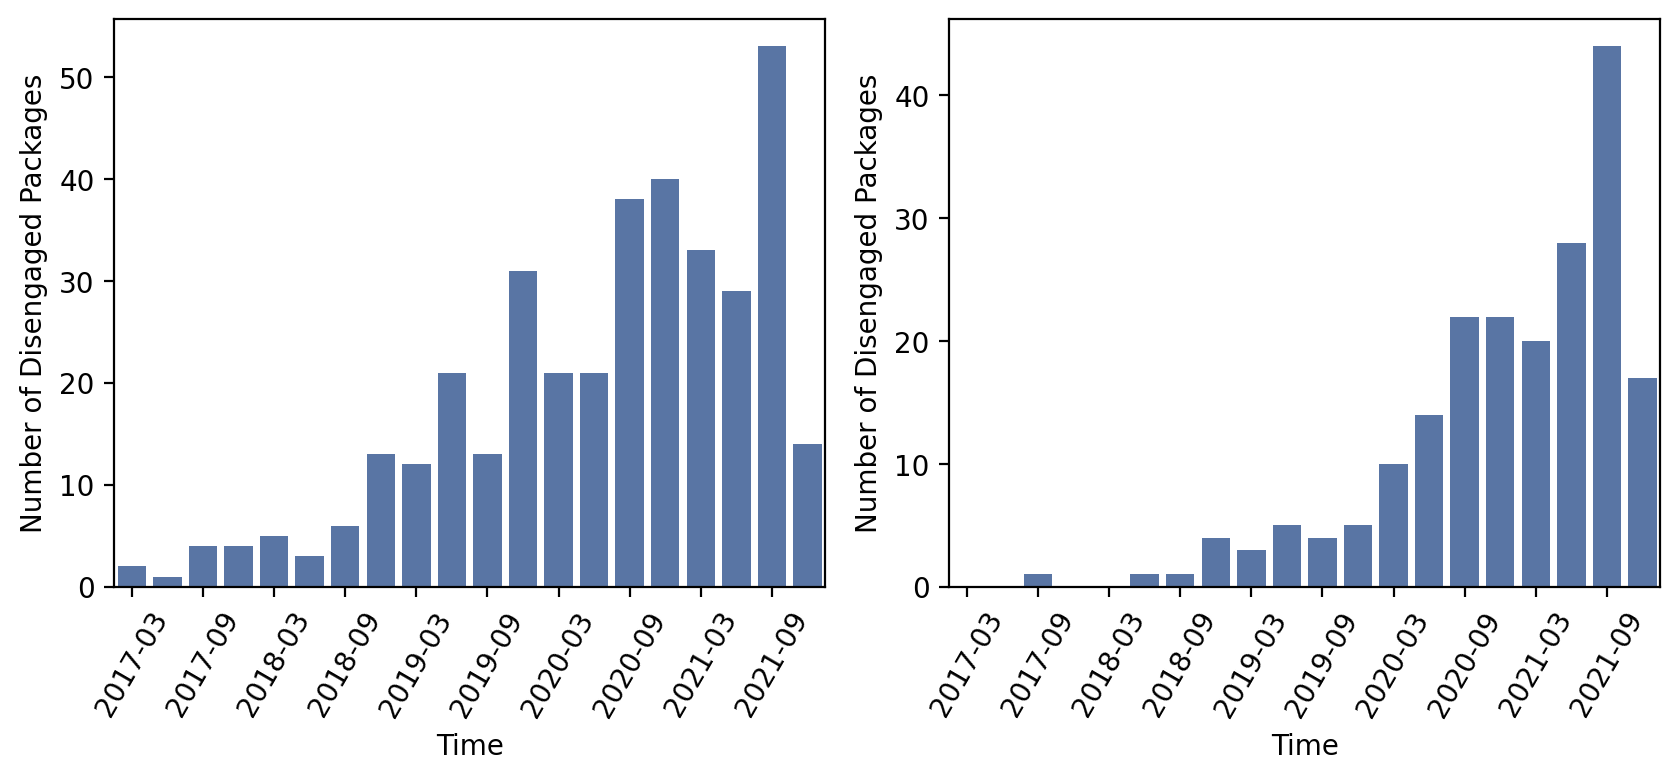

In [8]:
def plot_deprecate_trend():
    data = (
        left_packages.groupby(["framework", pd.Grouper(key="deprecate_time", freq="Q")])
        .size()
        .reset_index(name="Count")
        .pivot(columns="framework", index="deprecate_time", values="Count")
        .fillna(0)
        .astype(int)
        .reset_index()
    )
    data["deprecate_time"] = data["deprecate_time"].dt.strftime("%Y-%m")
    # return data

    fig, axes = plt.subplots(1, 2, figsize=(8.5, 4))
    sns.barplot(
        data=data,
        x="deprecate_time",
        y="TensorFlow",
        ax=axes[0],
        color=sns.color_palette("deep")[0],
    )
    sns.barplot(
        data=data,
        x="deprecate_time",
        y="PyTorch",
        ax=axes[1],
        color=sns.color_palette("deep")[0],
    )
    axes[0].set_xticks(np.arange(0, len(data), 2))
    axes[1].set_xticks(np.arange(0, len(data), 2))
    axes[0].tick_params("x", rotation=60)
    axes[1].tick_params("x", rotation=60)
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Number of Disengaged Packages")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Number of Disengaged Packages")
    plt.tight_layout()
    fig.savefig("figures/deprecation_trend.pdf", bbox_inches="tight")
    return data


plot_deprecate_trend()

In [29]:
reasons = pd.read_excel("data/labeled_detached_packages.xlsx")
reasons = reasons.merge(left_packages[["framework", "package", "deprecate_time"]])[
    ["framework", "package", "dependencies", "Final", "deprecate_time"]
]
reasons["quarter"] = reasons["deprecate_time"].dt.to_period("Q").dt.strftime("%Y-%m")

In [35]:
reasons["Final"] = reasons["Final"].str.split(",")
reasons = reasons.explode("Final")
reasons["Final"] =

,framework,package,dependencies,Final,deprecate_time,quarter
0,PyTorch,tonic,"torch,torchvision",Functionality:Framework-Free,2021-07-05,2021-09
1,PyTorch,clinica,"torch,torchvision",Functionality:Decoupling,2021-10-12,2021-12
2,PyTorch,alectio-sdk,"torch,torchtext,torchvision",Functionality:Framework-Free,2020-11-20,2020-12
3,PyTorch,pytorch-rex,torch,NaN,2021-07-28,2021-09
4,PyTorch,aim-cli,"torch,torchvision",Functionality:Framework-Free,2020-01-13,2020-03
...,...,...,...,...,...,...
560,TensorFlow,mindmeld,tensorflow,Installation:Trim Size,2019-12-11,2019-12
561,TensorFlow,DLHelper,tensorflow,NaN,2019-11-17,2019-12
562,TensorFlow,tuning,tensorflow-addons,NaN,2020-08-28,2020-09
563,TensorFlow,scArches,tensorflow,NaN,2020-12-14,2020-12


In [45]:
reasons[reasons["framework"] == "TensorFlow"].groupby(["quarter", "Final"])[
    "package"
].count().unstack(level=1).fillna(0).astype(int)

Final,Functionality:Decoupling,Functionality:Framework-Free,Functionality:Performance,Installation:Flexibility,Installation:Trim Size,Upstream:Bloated,Upstream:Incompatible
quarter,,,,,,,
2017-03,0,0,0,0,0,0,1
2017-09,0,0,0,0,0,0,2
2017-12,0,0,0,0,0,2,0
2018-03,0,0,0,0,0,0,1
2018-06,0,0,0,1,0,0,0
2018-09,0,0,0,0,0,1,0
2018-12,0,0,0,1,0,0,1
2019-03,0,0,1,1,0,0,2
2019-06,0,0,2,2,0,1,1


In [46]:
reasons[reasons["framework"] == "PyTorch"].groupby(["quarter", "Final"])[
    "package"
].count().unstack(level=1).fillna(0).astype(int)

Final,Functionality:Decoupling,Functionality:Framework-Free,Functionality:Performance,Installation:Flexibility,Installation:Trim Size,Upstream:Bloated,Upstream:Incompatible
quarter,,,,,,,
2019-03,0,0,1,0,0,0,0
2019-09,1,0,0,0,0,0,0
2019-12,1,0,1,0,0,0,0
2020-03,0,2,1,0,0,0,0
2020-06,0,0,1,0,2,1,2
2020-09,0,0,0,0,0,0,3
2020-12,0,2,0,0,2,1,1
2021-03,3,0,1,0,3,1,0
2021-06,2,0,0,0,3,1,2


In [10]:
#! /usr/bin/env python
# -*- coding: utf-8
"""
Python implementation of Krippendorff's alpha -- inter-rater reliability
(c)2011-17 Thomas Grill (http://grrrr.org)
Python version >= 2.4 required
"""

from __future__ import print_function

try:
    import numpy as np
except ImportError:
    np = None


def nominal_metric(a, b):
    return a != b


def interval_metric(a, b):
    return (a - b) ** 2


def ratio_metric(a, b):
    return ((a - b) / (a + b)) ** 2


def krippendorff_alpha(
    data,
    metric=interval_metric,
    force_vecmath=False,
    convert_items=float,
    missing_items=None,
):
    """
    Calculate Krippendorff's alpha (inter-rater reliability):

    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items

    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    """

    # number of coders
    m = len(data)

    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)

    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)

        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))

    units = dict(
        (it, d) for it, d in units.items() if len(d) > 1
    )  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values

    if n == 0:
        raise ValueError("No items to compare.")

    np_metric = (np is not None) and (
        (metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath
    )

    Do = 0.0
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du / float(len(grades) - 1)
    Do /= float(n)

    if Do == 0:
        return 1.0

    De = 0.0
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n * (n - 1))

    return 1.0 - Do / De if (Do and De) else 1.0

In [11]:
from collections import Counter

from nltk.metrics.distance import masi_distance

left_packages = pd.read_excel("data/labeled_detached_packages.xlsx")
left_packages = left_packages[pd.notna(left_packages["Final"])]

krippendorff_alpha(
    (
        left_packages[left_packages["Final"] != "Upstream:Detached"]["Inspector1"],
        left_packages[left_packages["Final"] != "Upstream:Detached"]["Inspector2"],
    ),
    metric=masi_distance,
    convert_items=lambda x: set(x.split(",")),
)

0.9273133447455415

In [12]:
transformed_data = []
for row in left_packages[["framework", "package", "Final"]].itertuples(index=False):
    framework, package, themes = row
    for theme in themes.split(","):
        if ":" in theme:
            level1, level2 = theme.split(":")
            if level2 != "Detached":
                transformed_data.append([framework, package, level1, level2])
        else:
            transformed_data.append([framework, package, theme, theme])

transformed_data = pd.DataFrame(
    transformed_data, columns=["framework", "package", "level1", "level2"]
)
transformed_data.head()

,framework,package,level1,level2
0,PyTorch,tonic,Functionality,Framework-Free
1,PyTorch,clinica,Functionality,Decoupling
2,PyTorch,alectio-sdk,Functionality,Framework-Free
3,PyTorch,aim-cli,Functionality,Framework-Free
4,PyTorch,lvsfunc,Installation,Trim Size


In [13]:
transformed_data.groupby("framework")["package"].nunique()

framework
PyTorch       44
TensorFlow    83
Name: package, dtype: int64

In [14]:
tmp_df = (
    transformed_data.groupby(["framework", "level1"])["package"].nunique().to_frame()
)
tmp_df.loc["PyTorch", "ratio"] = tmp_df.loc["PyTorch"]["package"].values / 44 * 100
tmp_df.loc["TensorFlow", "ratio"] = (
    tmp_df.loc["TensorFlow"]["package"].values / 83 * 100
)
tmp_df

package      ratio
framework  level1                           
PyTorch    Functionality       24  54.545455
           Installation        14  31.818182
           Upstream            13  29.545455
TensorFlow Functionality       27  32.530120
           Installation        25  30.120482
           Upstream            38  45.783133

In [15]:
tmp_df = (
    transformed_data.groupby(["framework", "level1", "level2"])["package"]
    .nunique()
    .to_frame()
)
tmp_df.loc["PyTorch", "ratio"] = tmp_df.loc["PyTorch"]["package"].values / 44 * 100
tmp_df.loc["TensorFlow", "ratio"] = (
    tmp_df.loc["TensorFlow"]["package"].values / 83 * 100
)
tmp_df

package      ratio
framework  level1        level2                            
PyTorch    Functionality Decoupling           13  29.545455
                         Framework-Free        5  11.363636
                         Performance           7  15.909091
           Installation  Flexibility           1   2.272727
                         Trim Size            13  29.545455
           Upstream      Bloated               4   9.090909
                         Incompatible         10  22.727273
TensorFlow Functionality Decoupling            9  10.843373
                         Framework-Free        3   3.614458
                         Performance          16  19.277108
           Installation  Flexibility          15  18.072289
                         Trim Size            10  12.048193
           Upstream      Bloated              15  18.072289
                         Incompatible         23  27.710843